<a href="https://colab.research.google.com/github/orlandoddi/Lectura-de-ECG-/blob/main/Prueba_lectura_datos2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Procesando registro 100...
Procesando registro 101...
Procesando registro 102...
Procesando registro 103...
Procesando registro 104...
Procesando registro 105...
Procesando registro 106...
Procesando registro 107...
Procesando registro 108...
Procesando registro 109...
Procesando registro 110...
Error al procesar registro 110: 404 Error: Not Found for url: https://physionet.org/files/mitdb/1.0.0/110.hea
Procesando registro 111...
Procesando registro 112...
Procesando registro 113...
Procesando registro 114...
Procesando registro 115...
Procesando registro 116...
Procesando registro 117...
Procesando registro 118...
Procesando registro 119...
Procesando registro 120...
Error al procesar registro 120: 404 Error: Not Found for url: https://physionet.org/files/mitdb/1.0.0/120.hea
Procesando registro 121...
Procesando registro 122...
Procesando registro 123...
Procesando registro 124...
Procesando registro 125...
Error al procesar registro 125: 404 Error: Not Found for url: https://physione

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Distribución de clases AAMI en el conjunto de prueba: Counter({np.str_('N'): 18070, np.str_('Q'): 2309, np.str_('V'): 1447, np.str_('S'): 526, np.str_('F'): 160})
Epoch 1/50
2252/2252 ━━━━━━━━━━━━━━━━━━━━ 80s 34ms/step - accuracy: 0.3872 - loss: 1.0765 - val_accuracy: 0.7970 - val_loss: 0.6174
Epoch 2/50
2252/2252 ━━━━━━━━━━━━━━━━━━━━ 67s 30ms/step - accuracy: 0.7005 - loss: 0.5553 - val_accuracy: 0.8060 - val_loss: 0.5515
Epoch 3/50
2252/2252 ━━━━━━━━━━━━━━━━━━━━ 72s 32ms/step - accuracy: 0.8410 - loss: 0.4139 - val_accuracy: 0.7861 - val_loss: 0.5976
Epoch 4/50
2252/2252 ━━━━━━━━━━━━━━━━━━━━ 68s 30ms/step - accuracy: 0.8824 - loss: 0.3158 - val_accuracy: 0.8752 - val_loss: 0.3622
Epoch 5/50
2252/2252 ━━━━━━━━━━━━━━━━━━━━ 82s 30ms/step - accuracy: 0.9012 - loss: 0.2528 - val_accuracy: 0.9604 - val_loss: 0.1583
Epoch 6/50
2252/2252 ━━━━━━━━━━━━━━━━━━━━ 85s 31ms/step - accuracy: 0.9221 - loss: 0.2238 - val_accuracy: 0.9462 - val_loss: 0.2176
Epoch 7/50
2252/2252 ━━━━━━━━━━━━━━━━━━━━ 66s

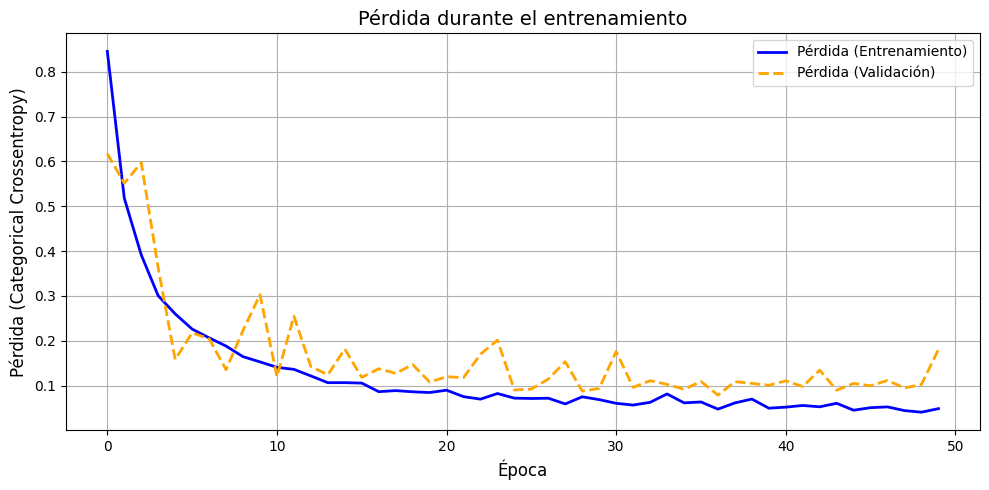

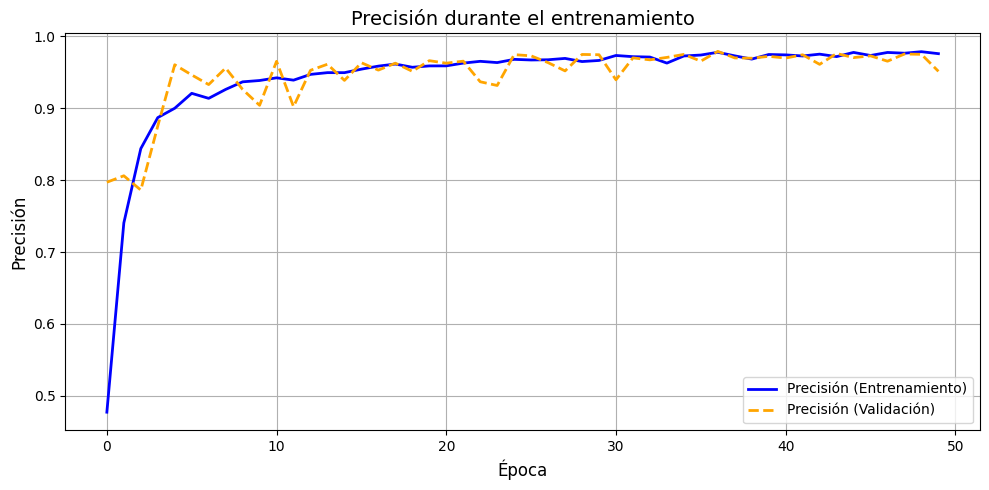

704/704 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step

Reporte de clasificación:
              precision    recall  f1-score   support

           F       0.20      0.96      0.33       160
           N       1.00      0.95      0.97     18070
           Q       0.93      0.98      0.96      2309
           S       0.73      0.91      0.81       526
           V       0.94      0.96      0.95      1447

    accuracy                           0.95     22512
   macro avg       0.76      0.95      0.80     22512
weighted avg       0.97      0.95      0.96     22512



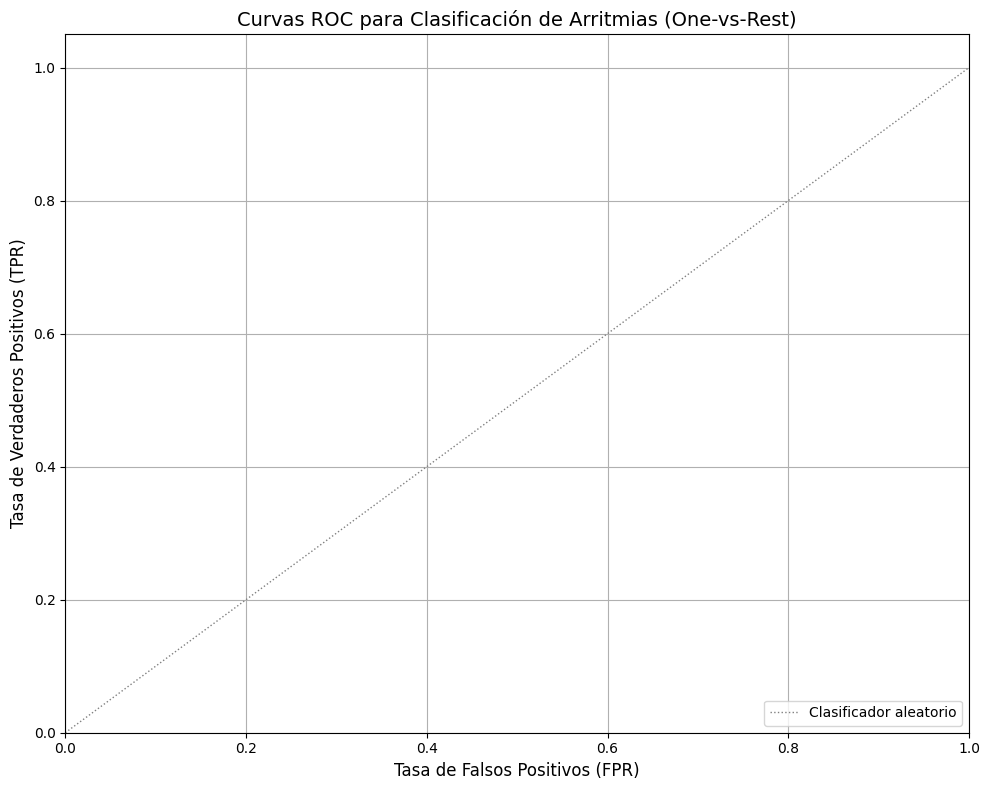


AUC por clase:
Clase F: nan
Clase N: nan
Clase Q: nan
Clase S: nan
Clase V: nan
AUC macro: nan


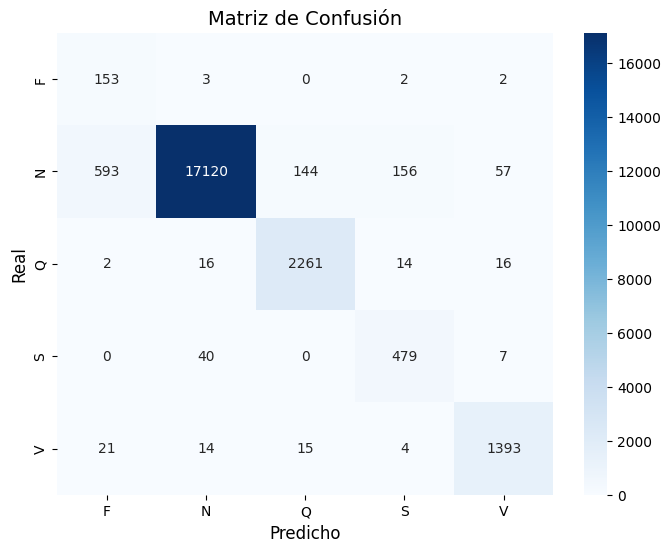

In [2]:
!pip install wfdb scipy numpy tensorflow scikit-learn matplotlib

import numpy as np
import wfdb
from scipy.signal import resample, butter, filtfilt, iirnotch
from sklearn.preprocessing import LabelEncoder, label_binarize
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Input, UpSampling1D
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix
from itertools import cycle
import seaborn as sns
from collections import Counter # Import Counter


# --- Funciones de preprocesamiento ---
def filtro_pasa_banda(senal, fs, lowcut=0.5, highcut=40.0, orden=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(orden, [low, high], btype='band')
    return filtfilt(b, a, senal)

def filtro_notch(senal, fs, freq_notch=60.0, Q=30.0):
    w0 = freq_notch / (fs / 2)
    b, a = iirnotch(w0, Q)
    return filtfilt(b, a, senal)

def normalizar_segmento(segmento):
    min_val = np.min(segmento)
    max_val = np.max(segmento)
    if max_val == min_val:
        return segmento - min_val
    return (segmento - min_val) / (max_val - min_val)

def ajustar_frecuencia(senal, frecuencia_original, frecuencia_deseada=360):
    if frecuencia_original == frecuencia_deseada:
        return senal
    num_muestras_nuevo = int(len(senal) * frecuencia_deseada / frecuencia_original)
    return resample(senal, num_muestras_nuevo)

def segmentar_y_normalizar(senal, picos, tamano_ventana=256): # Adjusted window size to be a power of 2
    segmentos = []
    indices_validos = []
    for i, pico in enumerate(picos):
        inicio = pico - tamano_ventana // 2
        fin = pico + tamano_ventana // 2
        if inicio >= 0 and fin <= len(senal):
            segmento = senal[inicio:fin]
            if len(segmento) == tamano_ventana:
                segmento_norm = normalizar_segmento(segmento)
                segmentos.append(segmento_norm)
                indices_validos.append(i)
    return np.array(segmentos), indices_validos

# --- Cargar y procesar MIT-BIH ---
registros = [str(i) for i in range(100, 235)]
segmentos_total = []
etiquetas_total = []
frecuencia_mit = 360

for reg in registros:
    try:
        print(f"Procesando registro {reg}...")
        record_mit = wfdb.rdrecord(reg, pn_dir='mitdb/')
        annotation_mit = wfdb.rdann(reg, extension='atr', pn_dir='mitdb/')
        senal_mit = record_mit.p_signal[:, 0]
        picos_mit = annotation_mit.sample
        etiquetas_mit = annotation_mit.symbol

        senal_mit_ajustada = ajustar_frecuencia(senal_mit, frecuencia_mit)
        senal_mit_filtrada = filtro_pasa_banda(senal_mit_ajustada, fs=frecuencia_mit)
        senal_mit_filtrada = filtro_notch(senal_mit_filtrada, fs=frecuencia_mit)

        segmentos_reg, indices_validos = segmentar_y_normalizar(senal_mit_filtrada, picos_mit)
        etiquetas_reg = [etiquetas_mit[i] for i in indices_validos]

        segmentos_total.extend(segmentos_reg)
        etiquetas_total.extend(etiquetas_reg)
    except Exception as e:
        print(f"Error al procesar registro {reg}: {str(e)}")
        continue

segmentos_total = np.array(segmentos_total)
etiquetas_total = np.array(etiquetas_total)
print(f"Total de segmentos procesados: {len(segmentos_total)}")

# --- Agrupar etiquetas AAMI ---
mapeo_aami = {'N': 'N', 'L': 'N', 'R': 'N', 'A': 'S', 'S': 'S', 'J': 'S', 'V': 'V', 'E': 'V', 'F': 'F', 'Q': 'Q', 'f': 'Q', '/': 'Q', '+': 'Q'}
etiquetas_aami = [mapeo_aami.get(e, 'Q') for e in etiquetas_total]

print("Distribución de clases AAMI en el conjunto total:", Counter(etiquetas_aami))

# Convertir a one-hot y obtener etiquetas numéricas
codificador = LabelEncoder()
etiquetas_numeros = codificador.fit_transform(etiquetas_aami)
etiquetas_onehot = to_categorical(etiquetas_numeros)

# --- Calcular pesos de clases ---
pesos = class_weight.compute_class_weight('balanced', classes=np.unique(etiquetas_numeros), y=etiquetas_numeros)
pesos_dict = dict(enumerate(pesos))
print("Pesos de clases:", pesos_dict)

# --- Autoencoder convolucional ---
input_shape = (256, 1) # Adjusted input shape
input_signal = Input(shape=input_shape)

# Encoder
x = Conv1D(32, kernel_size=5, activation='relu', padding='same')(input_signal)
x = MaxPooling1D(pool_size=2)(x)
x = Conv1D(16, kernel_size=5, activation='relu', padding='same')(x)
encoded = MaxPooling1D(pool_size=2)(x) # Output shape will be (64, 16)

# Decoder
x = Conv1D(16, kernel_size=5, activation='relu', padding='same')(encoded)
x = UpSampling1D(size=2)(x)
x = Conv1D(32, kernel_size=5, activation='relu', padding='same')(x)
x = UpSampling1D(size=2)(x) # Output shape will be (256, 32)
decoded = Conv1D(1, kernel_size=3, activation='linear', padding='same')(x)

autoencoder = Model(input_signal, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

encoder = Model(input_signal, encoded)

# Entrenar autoencoder
X_auto = segmentos_total[..., np.newaxis]
X_train_auto, X_val_auto = train_test_split(X_auto, test_size=0.2, random_state=42)
autoencoder.fit(X_train_auto, X_train_auto, epochs=20, batch_size=32, validation_data=(X_val_auto, X_val_auto))

# Extraer representaciones latentes
encoded_segments = encoder.predict(X_auto)
print("Forma de las representaciones latentes:", encoded_segments.shape)

# --- Modelo híbrido CNN-LSTM ---
modelo_hibrido = Sequential([
    Conv1D(32, kernel_size=5, activation='relu', input_shape=(encoded_segments.shape[1], encoded_segments.shape[2])), # Adjusted input shape
    MaxPooling1D(pool_size=2),
    Conv1D(64, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    LSTM(128, return_sequences=False),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(5, activation='softmax')
])
modelo_hibrido.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenar modelo híbrido con pesos de clase
X_train, X_test, y_train, y_test = train_test_split(encoded_segments, etiquetas_onehot, test_size=0.2, random_state=42, stratify=etiquetas_numeros) # Added stratify

# Verificar distribución de clases en el conjunto de prueba
y_test_classes_labels = codificador.inverse_transform(np.argmax(y_test, axis=1))
print("Distribución de clases AAMI en el conjunto de prueba:", Counter(y_test_classes_labels))


historia = modelo_hibrido.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, class_weight=pesos_dict)

# --- Evaluar ---
perdida, precision = modelo_hibrido.evaluate(X_test, y_test)
print(f"Precisión en prueba: {precision * 100:.2f}%")

# --- Generar gráficas de pérdida y precisión ---
#plt.style.use('seaborn')  # Estilo más limpio

# Gráfica de pérdida
plt.figure(figsize=(10, 5))
plt.plot(historia.history['loss'], label='Pérdida (Entrenamiento)', color='blue', linewidth=2)
plt.plot(historia.history['val_loss'], label='Pérdida (Validación)', color='orange', linestyle='--', linewidth=2)
plt.title('Pérdida durante el entrenamiento', fontsize=14)
plt.xlabel('Época', fontsize=12)
plt.ylabel('Pérdida (Categorical Crossentropy)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.savefig('/content/perdida.png')  # Guardar en Colab
plt.show()

# Gráfica de precisión
plt.figure(figsize=(10, 5))
plt.plot(historia.history['accuracy'], label='Precisión (Entrenamiento)', color='blue', linewidth=2)
plt.plot(historia.history['val_accuracy'], label='Precisión (Validación)', color='orange', linestyle='--', linewidth=2)
plt.title('Precisión durante el entrenamiento', fontsize=14)
plt.xlabel('Época', fontsize=12)
plt.ylabel('Precisión', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.savefig('/content/precision.png')  # Guardar en Colab
plt.show()

# --- Evaluación detallada por clase ---
y_pred = modelo_hibrido.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)
print("\nReporte de clasificación:")
print(classification_report(y_test_classes, y_pred_classes, target_names=codificador.classes_))

# --- Curvas ROC para multi-clase (one-vs-rest) ---

# Binarizar las etiquetas para one-vs-rest
y_test_bin = label_binarize(y_test_classes, classes=codificador.classes_)
n_classes = y_test_bin.shape[1]

# Obtener probabilidades de y_pred (ya las tienes)
# y_pred tiene forma (n_samples, n_classes)

# Calcular ROC para cada clase
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    # Check if the class is present in the test set and has at least two unique values (0 and 1)
    if np.sum(y_test_bin[:, i]) > 0 and len(np.unique(y_test_bin[:, i])) > 1:
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    else:
        # Handle the case where the class is not in the test set or only one class is present
        fpr[i], tpr[i], roc_auc[i] = np.nan, np.nan, np.nan # Or some other indicator
        print(f"Warning: Class {codificador.classes_[i]} not present or only one class present in test set for ROC calculation.")


# Calcular el promedio macro (promedio de todas las curvas)
# Exclude NaN values from the macro average calculation
valid_roc_auc = [roc_auc[i] for i in range(n_classes) if not np.isnan(roc_auc[i])]
if valid_roc_auc:
    # Recalculate all_fpr_valid based on valid classes
    valid_fpr = [fpr[i] for i in range(n_classes) if not np.isnan(fpr[i])]
    valid_tpr = [tpr[i] for i in range(n_classes) if not np.isnan(tpr[i])]

    all_fpr_valid = np.unique(np.concatenate(valid_fpr))
    mean_tpr = np.zeros_like(all_fpr_valid)
    for i in range(n_classes):
        if not np.isnan(roc_auc[i]):
             mean_tpr += np.interp(all_fpr_valid, fpr[i], tpr[i])
    mean_tpr /= len(valid_roc_auc)


    fpr["macro"] = all_fpr_valid
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
else:
     fpr["macro"] = np.nan
     tpr["macro"] = np.nan
     roc_auc["macro"] = np.nan


# Graficar las curvas ROC
plt.figure(figsize=(10, 8))
colors = cycle(['blue', 'red', 'green', 'orange', 'purple'])  # Colores para cada clase
for i, color in zip(range(n_classes), colors):
    if not np.isnan(roc_auc[i]): # Only plot if AUC is not NaN
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC clase {codificador.classes_[i]} (AUC = {roc_auc[i]:0.2f})')
if not np.isnan(roc_auc["macro"]):
    plt.plot(fpr["macro"], tpr["macro"], color='black', linestyle='--', lw=2,
             label=f'ROC macro (AUC = {roc_auc["macro"]:0.2f})')

plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle=':', label='Clasificador aleatorio')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)', fontsize=12)
plt.ylabel('Tasa de Verdaderos Positivos (TPR)', fontsize=12)
plt.title('Curvas ROC para Clasificación de Arritmias (One-vs-Rest)', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.savefig('/content/curvas_roc.png')  # Guardar en Colab o tu entorno
plt.show()

# Imprimir AUC por clase y macro
print("\nAUC por clase:")
for i in range(n_classes):
    print(f"Clase {codificador.classes_[i]}: {roc_auc[i]:.2f}")
print(f"AUC macro: {roc_auc['macro']:.2f}")
cm = confusion_matrix(y_test_classes, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=codificador.classes_, yticklabels=codificador.classes_)
plt.title('Matriz de Confusión', fontsize=14)
plt.xlabel('Predicho', fontsize=12)
plt.ylabel('Real', fontsize=12)
plt.savefig('/content/matriz_confusion.png')
plt.show()